In [ ]:
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 

from Toy_ML import MLModel, poly_fit
from plot_glodap import ArcticPlotter, OxygenIsotopePlots
from netcdf_climate_analysis_funcs import climdata, multiplot

with open("config.yaml", "r") as f:
    CONFIG = yaml.safe_load(f)


## 1. The Data

### 1.1. Load the data

#### 1.1.1. GloDAP

In [3]:
# Name of columns
latitude_field = "Latitude [degrees North]"
longitude_field = "Longitude [degrees East]"
temperature_field = "TEMPERATURE [DEG C]"
salinity_field = "SALNTY [PSS-78]"
depth_field = "DEPTH [M]"
oxygen_iso_field = "O18/O16 [/MILLE]"
reference_field = "Sample ID:INTEGER"
dt_format = "yyyy-mm-ddThh:mm:ss.sss"


In [4]:
# --- Load CSV ---
df = pd.read_csv(CONFIG["glodap"])

# --- Clean data ---
# Replace missing or placeholder values (like '**') with NaN
df = df.replace("**", np.nan)
df = df.dropna(subset=[longitude_field, latitude_field, salinity_field, oxygen_iso_field,temperature_field])


In [5]:
# Convert columns to numeric if necessary
df[longitude_field] = pd.to_numeric(df[longitude_field])
df[latitude_field] = pd.to_numeric(df[latitude_field])
df[salinity_field] = pd.to_numeric(df[salinity_field])
df[oxygen_iso_field] = pd.to_numeric(df[oxygen_iso_field])

df["datetime"] = pd.to_datetime(df[dt_format])
df = df.drop(columns=dt_format)


#### 1.1.2. BAS Pre-alpha

In [196]:
# Name of columns
latitude_field = "Latitude"
longitude_field = "Longitude"
temperature_field = "Temperature [C]"
salinity_field = "CTD Salinity"
depth_field = "Sample Depth (m)"
pressure_field = "CTD Pressure [dbar]"
oxygen_iso_field = "DELO18 [‰]"
reference_field = "Dataset"
dt_format = "Date"

In [197]:
# --- Load CSV ---
df_inp = pd.read_csv(CONFIG["BAS_prealpha"])


# --- Clean data ---
# Replace missing or placeholder values (like '**') with NaN
df = df_inp.replace(["-","**"], np.nan)
df = df.dropna(subset=[longitude_field, latitude_field, salinity_field, oxygen_iso_field, temperature_field, pressure_field])

# --- Convert columns to numeric ---
df[longitude_field] = pd.to_numeric(df[longitude_field])
df[latitude_field] = pd.to_numeric(df[latitude_field])
df[salinity_field] = pd.to_numeric(df[salinity_field])
df[temperature_field] = pd.to_numeric(df[temperature_field])
df[depth_field] = pd.to_numeric(df[depth_field])
df[pressure_field] = pd.to_numeric(df[pressure_field])
df[oxygen_iso_field] = pd.to_numeric(df[oxygen_iso_field])

df["datetime"] = pd.to_datetime(df[dt_format], format="mixed")
df = df.drop(columns=dt_format)

# Drop outlandish values
df = df.where((df[temperature_field] > -5) & (df[temperature_field] < 50), np.nan)
df = df.where(df[salinity_field] > 10, np.nan)
#df = df.where(df[pressure_field] < 180, np.nan)
df = df.where((df[oxygen_iso_field] > -10) & (df[oxygen_iso_field] < 10), np.nan)
df = df.where(df[longitude_field] < 180, np.nan)
df = df.dropna(subset=[longitude_field, latitude_field, salinity_field, oxygen_iso_field, temperature_field])


/tmp/ipykernel_2707344/1794516007.py:2: DtypeWarning:

Columns (2,11,16,17,18,20,22,23,25,30) have mixed types. Specify dtype option on import or set low_memory=False.



In [198]:
print(f"The original dataset has {df_inp.shape[0]} rows.")
print(f"After applying QC, the dataset has {df.shape[0]} rows.")

The original dataset has 89039 rows.
After applying QC, the dataset has 26616 rows.


### 1.2. What does the data look like? 

#### 1.2.1. Spatial plots

First let us consider the spatial sampling of the data. 

We see that there is quite a spread across the Arctic region.
* In the 1980s, most of the data is confined to the ~0E
* In the late 2010s, the data is around the pole
* Between these dates, the data is more spread

In [151]:
# Call class
arcticplot = ArcticPlotter(df[latitude_field], df[longitude_field])

(<Figure size 800x800 with 2 Axes>,
 <GeoAxes: title={'center': 'Arctic Sampling Locations from BAS Prealpha database'}>)

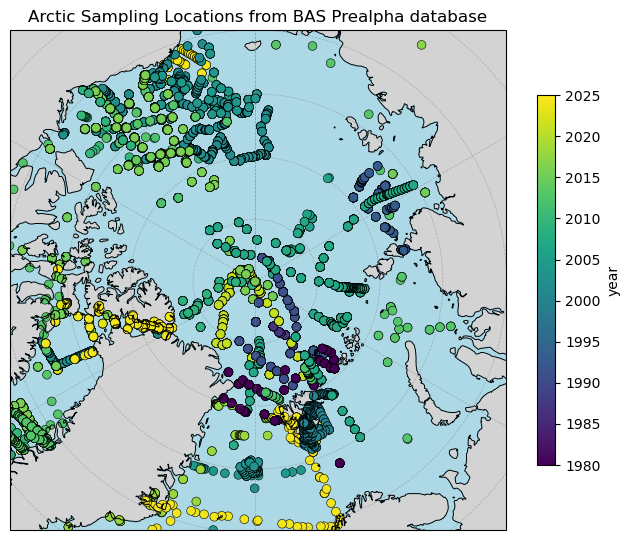

In [152]:
# Plot by year
arcticplot.title = "Arctic Sampling Locations from BAS Prealpha database"
arcticplot.plot(cbar_data=df["datetime"].dt.year)

A fundamental problem with this dataset is that there isn't enough data to be able to train the model on a regional basis, which we suggest will have a substantial influence on the oxygen isotopes. Unfortunately, there isn't a clear pattern in salinity, temperature or depth that would point to specific locations, as seen below

(<Figure size 800x800 with 2 Axes>,
 <GeoAxes: title={'center': 'Arctic Sampling Locations from BAS Prealpha database'}>)

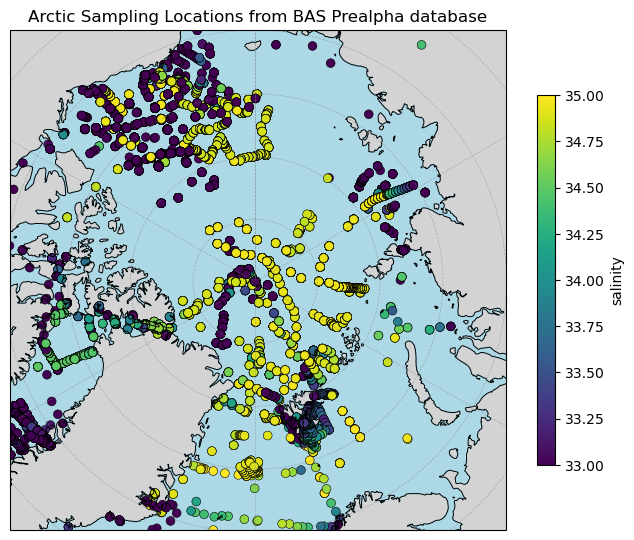

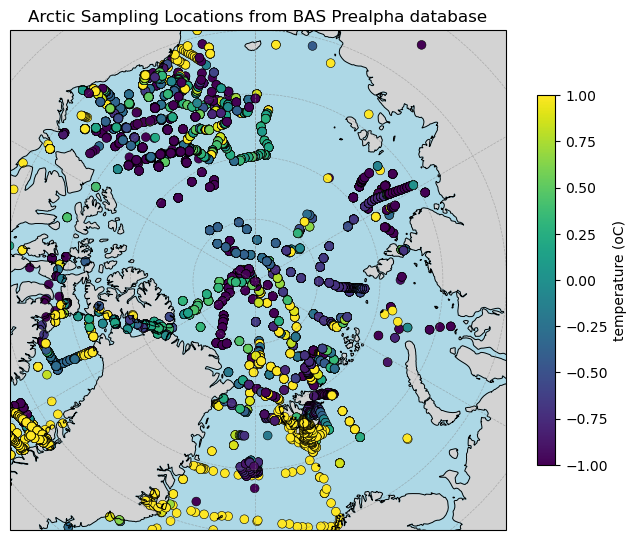

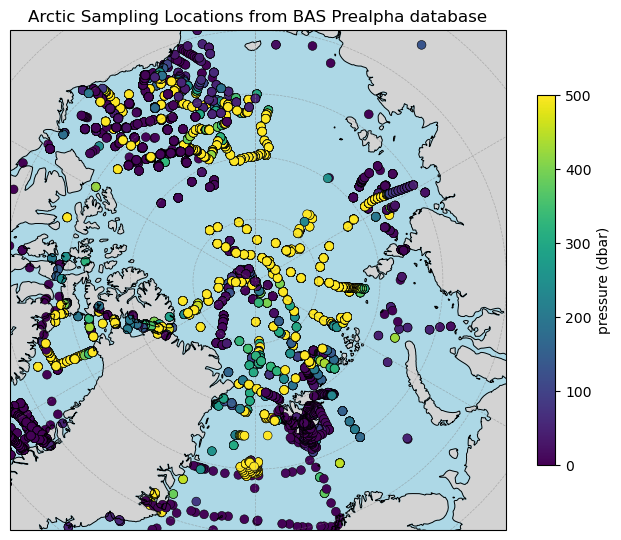

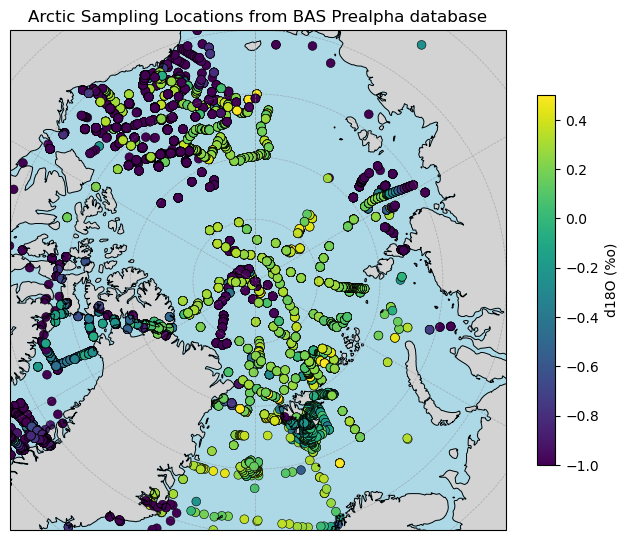

In [153]:
# Plot salinity over space
arcticplot.cbar_title = "salinity"
arcticplot.plot(cbar_data=df[salinity_field], vmin=33, vmax=35)

# Plot temperature over space
arcticplot.cbar_title = "temperature (oC)"
arcticplot.plot(cbar_data=df[temperature_field], vmin=-1, vmax=1)

# Plot depth over space
arcticplot.cbar_title = "pressure (dbar)"
arcticplot.plot(cbar_data=df[pressure_field], vmin=0, vmax=500)

# Plot oxygen isotope over space
arcticplot.cbar_title = "d18O (%o)"
arcticplot.plot(cbar_data=df[oxygen_iso_field], vmin=-1, vmax=0.5)


#### 1.2.2. δ¹⁸O plots

Now, let's consider the relationship between δ¹⁸O and temperature, salinity & depth. 

We can see that the strongest trend is in the salinity data. Temperature and depth are largely constant with δ¹⁸O except close to the origin (-2oC & 0m).

In [154]:
# Call class
d18o_plot = OxygenIsotopePlots(x=salinity_field, y=oxygen_iso_field, ref=reference_field)

# --- Scatter plot: d18O vs. Salinity ---
fig = d18o_plot.plot(df)
fig.show()

# --- Scatter plot: d18O vs. Salinity ---
d18o_plot.x = temperature_field
d18o_plot.title = "δ¹⁸O vs. Temperature from BAS Prealpha database"
d18o_plot.x_title = "temperature (oC)"

fig = d18o_plot.plot(df)
fig.show()

# --- Scatter plot: d18O vs. Pressure ---
d18o_plot.x = pressure_field
d18o_plot.title = "δ¹⁸O vs. Pressure from BAS Prealpha database"
d18o_plot.x_title = "pressure (dbar)"

fig = d18o_plot.plot(df)
fig.show()

### 1.3. Seasonality & annual variation

Let's start by considering how many data points are in each month. We can see that the vast majority are in October & September, with very few in May and July.

In [155]:
# Count the number of observations in each month of a year
df["datetime"].dt.month.value_counts().sort_index()

datetime
1     2594
2     1877
3     1339
4      887
5     1662
6     1988
7     2084
8     4372
9     4953
10    2384
11    1104
12    1372
Name: count, dtype: int64

To test this, we create a dataset that removes the summer months (May & July)

In [156]:
df_nosummer = df[df['datetime'].dt.month.isin([7, 8, 9, 10])] # Drop summer months

## 2. Train the model

Here, we train the model with 90% of the data and then apply the training to the final 10%. We then infer the error based on the difference between the model and the actual values in the final 10%. We use:
* RMSE: Higher RMSE means worse agreement
* R2: Closer to 0 means worse fit
* Absolute error percentiles (5th, 25th, 50th, 75th, 95th): Higher values in higher percentiles means the error is focused there

### 2.1. Train the model on all the data

First thing to do is train the model on all the data

In [168]:
# Create the 90% for training & 10% for inference
df_10 = df.sample(frac=0.10)  # 10% sample
df_90 = df.drop(df_10.index)  # get rest

(array([467., 132.,  81., 166., 193., 201., 445., 487., 236., 254.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <BarContainer object of 10 artists>)

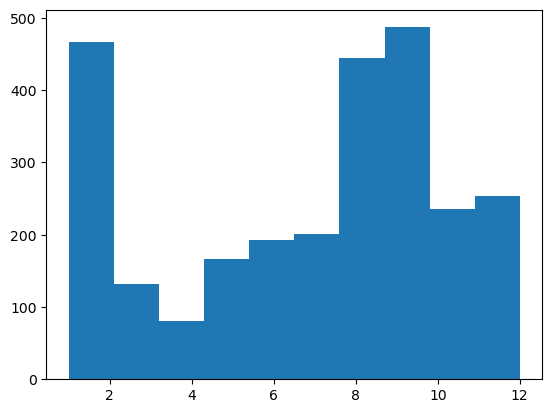

In [169]:
# Add a plot of distribution across the months for 10%
plt.hist(df_10['datetime'].dt.month)

In [158]:
# Call the ML model
ml_model = MLModel(df_90, df_10, [salinity_field, temperature_field, pressure_field], oxygen_iso_field)
# Training
trained_model = ml_model.training()
# Inference
model_test = ml_model.inference(trained_model[1], trained_model[0])

ML Predicted Oxygen RMSE: 0.28082873178837603
ML Predicted Oxygen R2: 0.9299335082918543
ML Predicted Oxygen Error Percentiles [0.0068137  0.03531894 0.08214365 0.18517043 0.55514382]


d18O is somewhere between -1 & 1 so these errors seem ok? Certainly, they are better than a polynomial fit as seen below

In [159]:
poly_test = poly_fit(df_90, 
         df_10, 
         salinity_field,
         oxygen_iso_field,
         create_plot=False
         )

Poly Predicted Oxygen RMSE: 0.43348586207194806
Poly Predicted Oxygen R2: 0.81544586731312
Poly Predicted Oxygen Error Percentiles [0.01494915 0.06968962 0.16846618 0.36184877 0.84996752]


In [160]:
print("Different fits to models")
print(f"RMSE: ML {model_test[1]} v polynomial {poly_test[1]}")
print(f"R2: full {model_test[2]} v polynomial {poly_test[2]}")
print(f"Error Percentiles: full {np.percentile(model_test[3], [5, 25, 50, 75, 95])} v polynomial {np.percentile(poly_test[3], [5, 25, 50, 75, 95])}")

Different fits to models
RMSE: ML 0.28082873178837603 v polynomial 0.43348586207194806
R2: full 0.9299335082918543 v polynomial 0.81544586731312
Error Percentiles: full [0.0068137  0.03531894 0.08214365 0.18517043 0.55514382] v polynomial [0.01494915 0.06968962 0.16846618 0.36184877 0.84996752]


### 2.2. Train the model without summer

First thing to do is train the model on all the data

In [161]:
# Create the 90% for training & 10% for inference
df_10_nosumm = df_nosummer.sample(frac=0.10)  # 10% sample
df_90_nosumm = df_nosummer.drop(df_10_nosumm.index)  # get rest

In [162]:
# Change input to exclude summer months
ml_model.df_10 = df_10_nosumm
ml_model.df_90 = df_90_nosumm

# Training
trained_model_nosumm = ml_model.training()
# Inference
model_test_nosumm = ml_model.inference(trained_model_nosumm[1], trained_model_nosumm[0],)

ML Predicted Oxygen RMSE: 0.3482443884389936
ML Predicted Oxygen R2: 0.9038389388257473
ML Predicted Oxygen Error Percentiles [0.0068225  0.03707769 0.09317224 0.20309254 0.72470757]


In [163]:
print("Different fits to models")
print(f"RMSE: full {model_test[1]} v no-summer {model_test_nosumm[1]}")
print(f"R2: full {model_test[2]} v no-summer {model_test_nosumm[2]}")
print(f"Error Percentiles: full {np.percentile(model_test[3], [5, 25, 50, 75, 95])} v no-summer {np.percentile(model_test_nosumm[3], [5, 25, 50, 75, 95])}")

Different fits to models
RMSE: full 0.28082873178837603 v no-summer 0.3482443884389936
R2: full 0.9299335082918543 v no-summer 0.9038389388257473
Error Percentiles: full [0.0068137  0.03531894 0.08214365 0.18517043 0.55514382] v no-summer [0.0068225  0.03707769 0.09317224 0.20309254 0.72470757]


Removing the summer months reduces the RMSE and increases the R2, suggesting that the model works better without them.

### 2.3. Train the model using different input variables

Now, let's consider how the ML model works if we use different input variables. The full model inputs salinity, temperature and depth. According to the plots in Sec. 1.2.2, salinity has the strongest relationship with d18O, so let's test that. Let's try:
* Salinity only
* Temperature only
* Depth only
* Salinity & temperature
* Salinity & depth

In [173]:
## Salinity only
sal_ml_model = MLModel(df_90, df_10, [salinity_field, longitude_field, latitude_field], oxygen_iso_field)

sal_trained = sal_ml_model.training()
sal_model_test = sal_ml_model.inference(sal_trained[1], sal_trained[0])

ML Predicted Oxygen RMSE: 0.26550448779651337
ML Predicted Oxygen R2: 0.9382944378126121
ML Predicted Oxygen Error Percentiles [0.00687105 0.03718955 0.08439172 0.19150075 0.50173449]


In [174]:
## Temperature only
te_ml_model = MLModel(df_90, df_10, [temperature_field, longitude_field, latitude_field], oxygen_iso_field)

te_trained = te_ml_model.training()
te_model_test = te_ml_model.inference(te_trained[1], te_trained[0])

ML Predicted Oxygen RMSE: 0.7061355432794084
ML Predicted Oxygen R2: 0.281348024298408
ML Predicted Oxygen Error Percentiles [0.01270731 0.0702871  0.20605364 0.57327347 1.48521715]


In [175]:
## Pressure only
pre_ml_model = MLModel(df_90, df_10, [pressure_field, longitude_field, latitude_field], oxygen_iso_field)

pre_trained = pre_ml_model.training()
pre_model_test = pre_ml_model.inference(pre_trained[1], pre_trained[0])

ML Predicted Oxygen RMSE: 0.4835195035710678
ML Predicted Oxygen R2: 0.7622313364506443
ML Predicted Oxygen Error Percentiles [0.01314238 0.06643886 0.15657362 0.35210161 0.89123952]


In [176]:
## Salinity & temperature
salte_ml_model = MLModel(df_90, df_10, [salinity_field, temperature_field, longitude_field, latitude_field], oxygen_iso_field)

salte_trained = salte_ml_model.training()
salte_model_test = salte_ml_model.inference(salte_trained[1], salte_trained[0])

ML Predicted Oxygen RMSE: 0.25218944082906036
ML Predicted Oxygen R2: 0.9450268283184728
ML Predicted Oxygen Error Percentiles [0.00501986 0.02873876 0.06601375 0.14612206 0.48498706]


In [177]:
## Salinity & pressure
salpre_ml_model = MLModel(df_90, df_10, [salinity_field, pressure_field, longitude_field, latitude_field], oxygen_iso_field)

salpre_trained = salpre_ml_model.training()
salpre_model_test = salpre_ml_model.inference(salpre_trained[1], salpre_trained[0])

ML Predicted Oxygen RMSE: 0.2612883730590977
ML Predicted Oxygen R2: 0.9406991461974147
ML Predicted Oxygen Error Percentiles [0.00589583 0.03086172 0.07466237 0.16533738 0.49931475]


In [178]:
## Temperature & pressure
tepre_ml_model = MLModel(df_90, df_10, [temperature_field, pressure_field, longitude_field, latitude_field], oxygen_iso_field)

tepre_trained = tepre_ml_model.training()
tepre_model_test = tepre_ml_model.inference(tepre_trained[1], tepre_trained[0])

ML Predicted Oxygen RMSE: 0.44333024176018354
ML Predicted Oxygen R2: 0.805079335867153
ML Predicted Oxygen Error Percentiles [0.01088411 0.05023931 0.11682274 0.26863363 0.8095304 ]


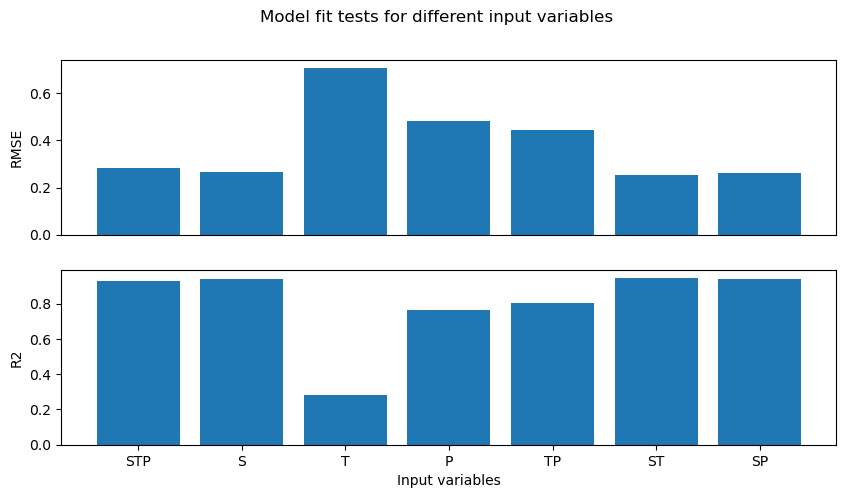

In [179]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10,5))
yname = ["RMSE", "R2"]

fig.suptitle("Model fit tests for different input variables")

for i, ax in enumerate(axs):
    ax.bar(["STP", "S", "T", "P", "TP", "ST", "SP"], [model_test[i+1], sal_model_test[i+1], te_model_test[i+1], pre_model_test[i+1], tepre_model_test[i+1], salte_model_test[i+1], salpre_model_test[i+1]])
    ax.set_ylabel(yname[i])
    ax.set_xlabel("Input variables")
    if i<len(axs)-1:
        ax.set_xticks([])
        ax.set_xlabel("")
        

It is clear that salinity is the most important variable in the model. If we don't use it, the error blows up significantly. Indeed, we see that while it is better to include all the variables, salinity does a reasonable job on its own.

In [48]:
print(f"RMSE: all variables {model_test[1]} v salinity only {sal_model_test[1]}")
print(f"R2: all variables {model_test[2]} v salinity only {sal_model_test[2]}")

RMSE: all variables 0.31145203251209547 v salinity only 0.3722078534393246
R2: all variables 0.9305485847841977 v salinity only 0.8978704938566292


## 3. Arctic Ocean Reanalysis

Now that we have trained our model, we can apply it the Arctic Ocean Reanalysis. This contains temperature and salinity: now we can add our oxygen isotope tracer!

### 3.1. Load AOR data

In [188]:
aor = climdata(CONFIG["arctic_reanalysis"])

sal_aor = aor.so
temp_aor = aor.thetao

In [209]:
df201609 = df[(df["datetime"].dt.year == 2016) & (df["datetime"].dt.month == 9)]

print(df201609)

              Dataset      Time  Latitude  Longitude  Temperature [C]  \
0      ArcticNet_data  17:25:00   68.4975   -56.7956           3.8784   
1      ArcticNet_data  17:33:00   68.4975   -56.7951          -0.9372   
2      ArcticNet_data  17:34:00   68.4975   -56.7948          -1.5417   
3      ArcticNet_data  17:38:00   68.4973   -56.7940          -0.9740   
4      ArcticNet_data  17:40:00   68.4973   -56.7936           0.5214   
...               ...       ...       ...        ...              ...   
80635       JOIS_2016  21:00:00   73.0007  -150.0043          -0.8374   
80636       JOIS_2016  21:00:00   73.0007  -150.0043          -0.1874   
80637       JOIS_2016  21:00:00   73.0007  -150.0043          -0.3570   
80638       JOIS_2016  21:00:00   73.0007  -150.0043           0.4862   
80639       JOIS_2016  21:00:00   73.0007  -150.0043           0.5068   

       CTD_TMP_WOCE_FLAG  CTD Pressure [dbar]  Sample Depth (m)  DELO18 [‰]  \
0                    NaN              362.85

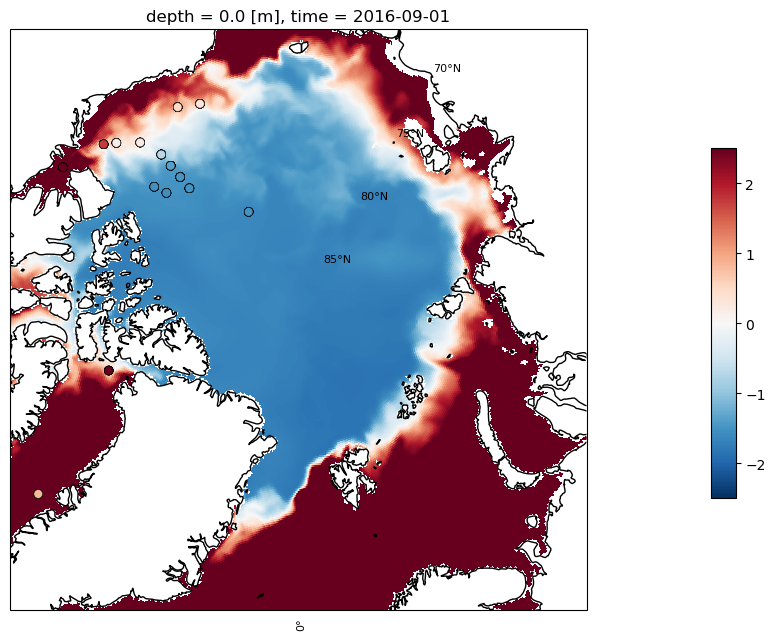

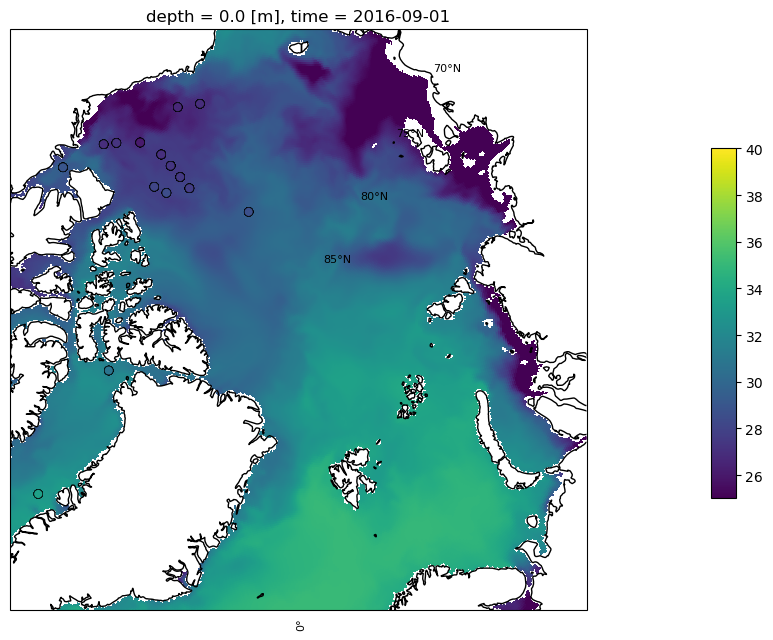

In [213]:
fig, ax, p = multiplot(temp_aor.sel(time="2016-09-01"), vmin=-2.5, vmax=2.5, cmap="RdBu_r", map_type="NorthPolarStereo", xyreg=(False,(70,90)))


# --- Plot the sample points ---
sc = ax.scatter(
    df201609[longitude_field],
    df201609[latitude_field],
    c=df201609[temperature_field],
    s=40,
    cmap="RdBu_r",
    transform=ccrs.PlateCarree(),
    edgecolor="black",
    linewidth=0.4,
    vmin=-2.5,
    vmax=2.5,
)

fig, ax, p = multiplot(sal_aor.sel(time="2016-09-01"), vmin=25, vmax=40, cmap="viridis", map_type="NorthPolarStereo", xyreg=(False,(70,90)))

# --- Plot the sample points ---
sc = ax.scatter(
    df201609[longitude_field],
    df201609[latitude_field],
    c=df201609[salinity_field],
    s=40,
    cmap="viridis",
    transform=ccrs.PlateCarree(),
    edgecolor="black",
    linewidth=0.4,
    vmin=25,
    vmax=40,
)

In [ ]:
df[(df["datetime"].dt.year == 2016)]

Dataset      Time  Latitude  Longitude  Temperature [C]  \
0      ArcticNet_data  17:25:00   68.4975   -56.7956           3.8784   
1      ArcticNet_data  17:33:00   68.4975   -56.7951          -0.9372   
2      ArcticNet_data  17:34:00   68.4975   -56.7948          -1.5417   
3      ArcticNet_data  17:38:00   68.4973   -56.7940          -0.9740   
4      ArcticNet_data  17:40:00   68.4973   -56.7936           0.5214   
...               ...       ...       ...        ...              ...   
80815       JOIS_2016  17:18:00   70.2298  -140.0020          -1.2330   
80816       JOIS_2016  17:18:00   70.2298  -140.0020          -0.6705   
80817       JOIS_2016  17:18:00   70.2298  -140.0020          -0.2162   
80818       JOIS_2016  17:18:00   70.2298  -140.0020           1.5399   
80819       JOIS_2016  17:18:00   70.2298  -140.0020           1.1189   

       CTD_TMP_WOCE_FLAG  CTD Pressure [dbar]  Sample Depth (m)  DELO18 [‰]  \
0                    NaN              362.852            -999.0       0.420   
1                    NaN               60.178            -999.0      -0.240   
2                    NaN               50.106            -999.0      -0.220   
3                    NaN               39.998            -999.0      -0.170   
4                    NaN               30.177            -999.0      -0.350   
...                  ...                  ...               ...         ...   
80815                NaN               85.318               NaN      -1.758   
80816                NaN               71.596               NaN      -2.087   
80817                NaN               50.604               NaN      -2.457   
80818                NaN               21.647               NaN      -3.625   
80819                NaN                5.614               NaN      -3.807   

       DELO18_WOCE_FLAG_Translated  ... BTLNBR Event  Rosette Position  \
0                              2.0  ...      1   NaN               NaN   
1                              6.0  ...      6   NaN               NaN   
2                              3.0  ...      7   NaN               NaN   
3                              3.0  ...     11   NaN               NaN   
4                              3.0  ...     13   NaN               NaN   
...                            ...  ...    ...   ...               ...   
80815                          2.0  ...   10.0   NaN               NaN   
80816                          2.0  ...   11.0   NaN               NaN   
80817                          2.0  ...   12.0   NaN               NaN   
80818                          2.0  ...   15.0   NaN               NaN   
80819                          3.0  ...   16.0   NaN               NaN   

       Platform  BIOPOLE Freshwater Freshwater Source LAND_BASED Comments  \
0           NaN    False      False               NaN      False      NaN   
1           NaN    False      False               NaN      False      NaN   
2           NaN    False      False               NaN      False      NaN   
3           NaN    False      False               NaN      False      NaN   
4           NaN    False      False               NaN      False      NaN   
...         ...      ...        ...               ...        ...      ...   
80815       NaN    False      False               NaN      False      NaN   
80816       NaN    False      False               NaN      False      NaN   
80817       NaN    False      False               NaN      False      NaN   
80818       NaN    False      False               NaN      False      NaN   
80819       NaN    False      False               NaN      False      NaN   

        datetime  
0     2016-09-06  
1     2016-09-06  
2     2016-09-06  
3     2016-09-06  
4     2016-09-06  
...          ...  
80815 2016-10-15  
80816 2016-10-15  
80817 2016-10-15  
80818 2016-10-15  
80819 2016-10-15  

[1490 rows x 31 columns]